## Dynamic simulation of a Bridge

In this example, we consider the simulation of the same bridge to some initial conditions.


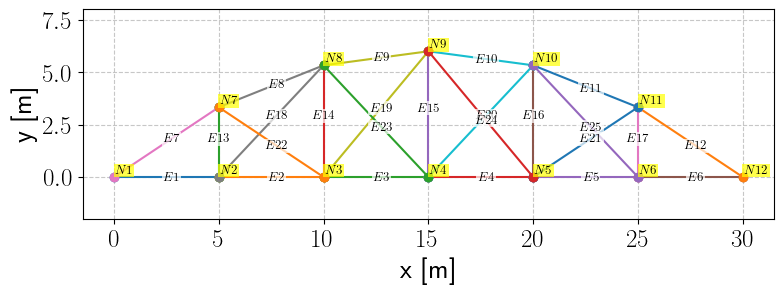

In [1]:
# As usual we start by generating the coordinates and mesh (same as before)
import numpy as np
from src.postprocessing.plot_mesh import plot_truss_structure_2d
import matplotlib.pyplot as plt


# Define parameters
E = 200e3 # [Pa]
rho = 1.0 # [kg/m^3]
A = 1     # [m^2]

EA = E * A 
rhoA = rho * A

l = 5.0
h1 = 3.33
h2 = 5.33
h3 = 6.0

# Node coordinates
bottom_indices = np.arange(1, 6)  
top_indices = np.arange(6, 11)

# Create coordinates matrix
n_nodes = 12
coordinates = np.zeros((n_nodes, 2))

# Assign coordinates
# Left (first node) and right (last) points
left_id = 0
right_id = 11
coordinates[left_id] = [0.0, 0.0]
coordinates[right_id] = [6*l, 0.0]

# Bottom points
for i in bottom_indices:
    coordinates[i] = [i*l, 0.0]

# Top points
for i, coord_id in enumerate(top_indices):
    h_i = [h1, h2, h3, h2, h1][i]
    coordinates[coord_id] = [(i+1)*l, h_i]


# Create connectivity table
num_bottom_lines = 6        # left + 5 bottom points + right = 7 points, 6 lines
num_top_lines = 6           # left + 5 top points + right = 7 points, 6 lines
num_vertical_lines = 5
num_diagonal_lines = 4 * 2  # 4 left diagonals + 4 right diagonals

n_elements = num_bottom_lines + num_top_lines + num_vertical_lines + num_diagonal_lines
connectivity_table = np.zeros((n_elements, 2), dtype=int)

element_id = 0 
# Bottom lines
for i in range(num_bottom_lines):
    if i == 0:
        # First bottom line connects left to first bottom point
        connectivity_table[element_id] = [left_id, bottom_indices[0]]
    elif i == num_bottom_lines - 1:
        # Last bottom line connects last bottom point to right
        connectivity_table[element_id] = [bottom_indices[-1], right_id]
    else:
        # Middle bottom lines connect adjacent bottom points
        connectivity_table[element_id] = [bottom_indices[i-1], bottom_indices[i]]
    element_id +=1

# Top lines
for i in range(num_top_lines):
    if i == 0:
        # First top line connects left to first top point
        connectivity_table[element_id] = [0, top_indices[0]]
    elif i == num_top_lines - 1:
        # Last top line connects last top point to right
        connectivity_table[element_id] = [top_indices[-1], right_id]
    else:
        # Middle top lines connect adjacent top points
        connectivity_table[element_id] = [top_indices[i-1], top_indices[i]]
    element_id +=1

# Vertical lines
for i in range(num_vertical_lines):
    connectivity_table[element_id] = [bottom_indices[i], top_indices[i]]
    element_id +=1

# Right diagonal lines (bottom to top)
for i in range(num_vertical_lines - 1):
    connectivity_table[element_id] = [bottom_indices[i], top_indices[i+1]]
    element_id +=1

# Left diagonal lines (top to bottom)
for i in range(num_vertical_lines - 1):
    connectivity_table[element_id] = [top_indices[i], bottom_indices[i+1]]
    element_id += 1

# plt.plot(coordinates[:, 0], coordinates[:, 1], 'o')
ax = plot_truss_structure_2d(coordinates, connectivity_table, 
                        xlabel='x [m]', 
                        ylabel='y [m]', 
                        ylim=[-2, 8])


We now solve the modal analysis for the bridge, to find the frequency of vibration and the mode shapes.

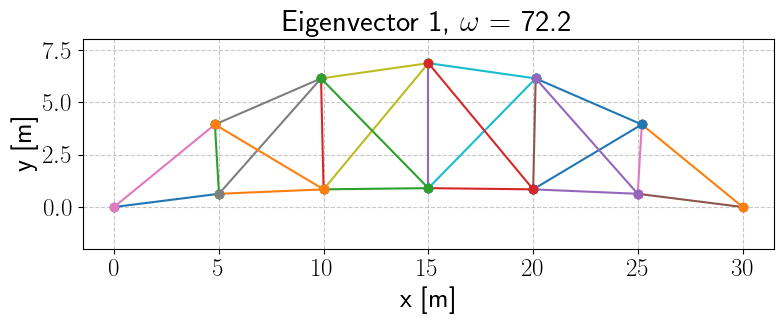

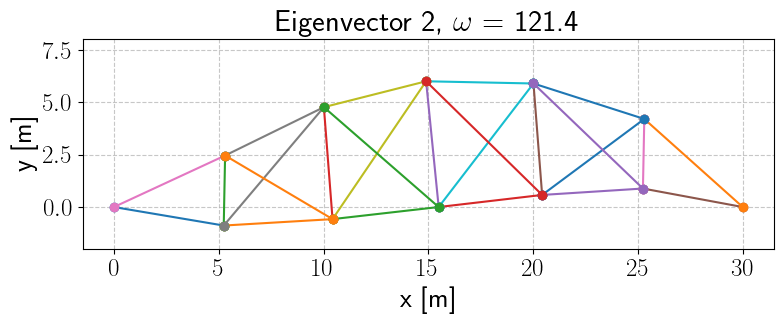

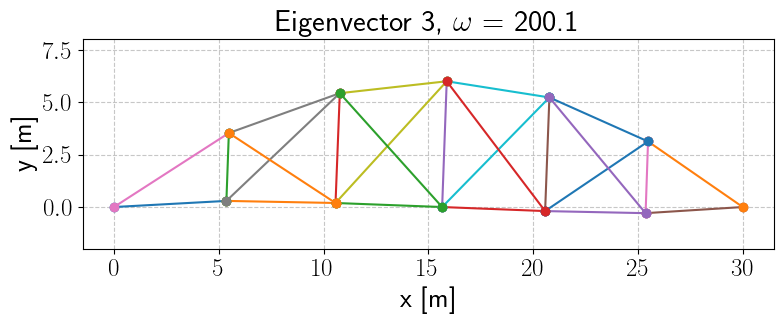

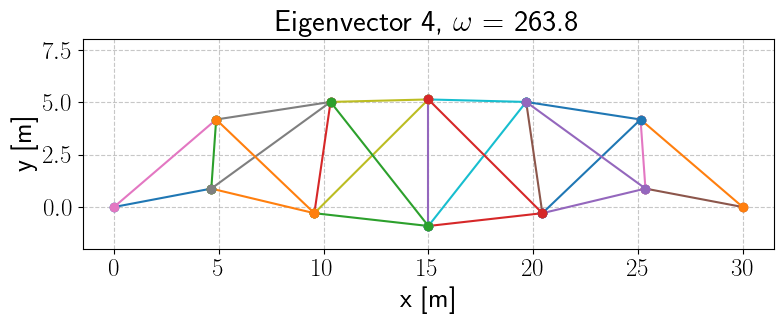

In [2]:
from src.fem.assemble_matrices import assemble_stiffness_truss_2d, assemble_mass_truss_2d
from src.fem.boundary_conditions import apply_bcs, restore_data
from src.linear_algebra.solve_eigenproblem import solve_sparse_generalized_eigenproblem


n_dofs = n_nodes*2


K = assemble_stiffness_truss_2d(coordinates, connectivity_table, EA)
M = assemble_mass_truss_2d(coordinates, connectivity_table, rhoA)

dofs_bcs = [2*left_id, 2*left_id+1, 2*right_id, 2*right_id+1]

K_red = apply_bcs(K, dofs_bcs)
M_red = apply_bcs(M, dofs_bcs)

omega_squared, modes_red = solve_sparse_generalized_eigenproblem(K_red, M_red, k=4)
omega_vec = np.sqrt(np.real(omega_squared))

eigenvectors = restore_data(modes_red, dofs_bcs)

n_modes = 4
for ii in range(n_modes):
    coordinates_eigenmodes = coordinates + eigenvectors[:, ii].reshape(-1, 2)
    ax = plot_truss_structure_2d(coordinates_eigenmodes, connectivity_table, 
                        xlabel='x [m]', 
                        ylabel='y [m]', 
                        ylim=[-2, 8], 
                        show_element_labels=False,
                        show_node_labels=False,
                        title=f'Eigenvector {ii+1}, $\omega$ = {omega_vec[ii]:.1f}')


Now an initial condition for the velocity field is considered. In particular, we consider an initial velocity given by the first eigenmode.

NameError: name 'animation' is not defined

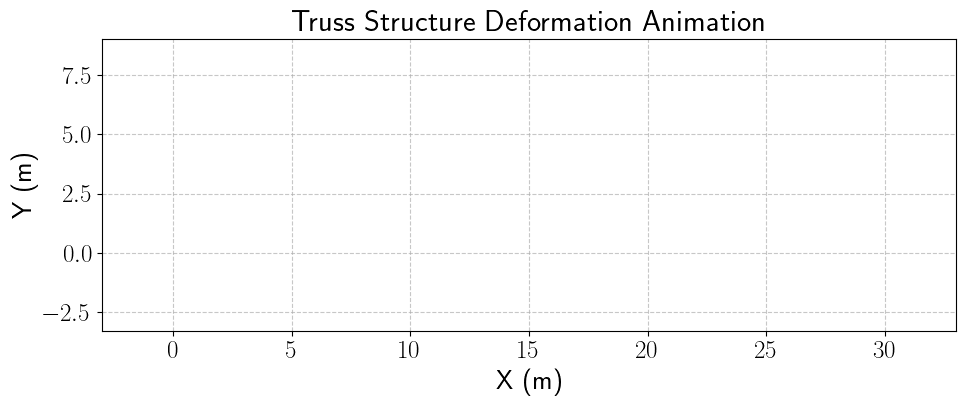

In [ ]:
from src.linear_algebra.time_integration import newmark
from src.postprocessing.animate_mesh import animate_truss_structure
from IPython.display import HTML
import os 

# Initial conditions corresponding to first mode
num_mode = 2

q0 = np.zeros(n_dofs)
v0 = np.zeros(n_dofs)

q0[::2] = eigenvectors[0::2, num_mode]
q0[1::2] = eigenvectors[1::2, num_mode]

q0_red = np.delete(q0, dofs_bcs)
v0_red = np.delete(v0, dofs_bcs)

# Solve dynamic response
T_end = 1  # Total simulation time
dt = 2*np.pi/omega_vec[num_mode]/10  # Time step
n_times = int(np.ceil(T_end/dt))
q_array_red, v_array_red = newmark(q0_red, v0_red, M_red, K_red, dt, n_times)

q_array = restore_data(q_array_red, dofs_bcs)
# Post-processing
coordinates_deformed = np.zeros((n_nodes, 2, n_times))
for t in range(n_times):
    coordinates_deformed[:, :, t] = coordinates + q_array[:, t].reshape(-1, 2)

folder_res = './PC1/truss_example_3/results/'
if not os.path.exists(folder_res):
    os.makedirs(folder_res)

# np.save(folder_res + 'coordinates_deformed.npy', coordinates_deformed)
animation = animate_truss_structure(
        coordinates_deformed, 
        connectivity_table,
        title="Truss Structure Deformation Animation",
        xlabel="X (m)",
        ylabel="Y (m)",
        interval=50,  # milliseconds between frames
        show_element_labels=True,
        show_node_labels=True,
        show_time=True,
        time_values=np.linspace(0, T_end, n_times+1),
        time_format="t = {:.2f} s",
        save_path=folder_res + "truss_animation.mp4"  # Uncomment to save animation
    )
    
HTML(animation.to_jshtml())